### Contents of Notebook

* Purpose
* Variables and Data Acquisition
* Data Cleaning
* Data Visualization & Insights
* Regression Results
* Q&A

### Purpose

From low-budget Indie films to star-studded blockbusters, movies come in many different shapes and sizes. Making a movie is a high-risk, high-reward enterprise; one that can take years to come to fruition. Countless hours go into writing the story, casting actors, filming, and editing. Needless to say, undertaking a movie's production is no easy task and requires meticulous planning. Production companies invest a lot of resources into a movie's production. So, a production company needs strong justification to pursue a movie's production. A simple indicator of a potential movie's success is how much revenue it will make. 

The goal of our project was to build a linear regression model to predict a potential movie's revenue.

### Variables & Data Acquistion

Before building our model and conducting our analysis, we collected data from various sources. We began by brainstorming factors that could affect a movie's ability to generate revenue. In addition to variables directly associated with a movie (like genre, budget, and cast), we wanted to know if external factors could affect revenue. We thought release dates near U.S. holidays and major U.S. sport championships could contribute to a movie's eventual success. We also speculated macroeconomic data like median U.S. household income could affect moviegoers' desire to see a movie. 

Our data came from:

* Movie dataset - Kaggle - The Movie Database (TMDB)
* U.S. holidays - Python holidays package
* Big Four (NFL, NHL, MLB, NBA) championship dates - various websites
* Median U.S. household income - U.S. Census Bureau
* U.S. population - Statista
* A-list celebrities - various websites

### Data Cleaning

We imported our data using various pandas read_ functions and several defined functions.

In [1]:
path = ''

In [2]:
import pandas as pd
import numpy as np
import json
import datetime as dt
from datetime import date, datetime
import re
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)

The Kaggle TMDB dataset had both movie and credit datasets. So, we concatenated the two into a single DataFrame.

In [3]:
# using one single function for preprocessing the movies csv
def preprocess_movies(movies_file): # making file path as the argument since directory changes from user to user
    # reading csv file which is TMDB movies data source
    df = pd.read_csv(movies_file)
    # converting release date to datetime format
    df['release_date'] = pd.to_datetime(df['release_date'])
    # few of our fields are stored as a list of dictionaries in string data format
    # we are going to unpack them and make them actual dictionaries
    # we begin by first listing out the column names which are stored as such
    dict_columns = ['genres', 'production_countries', 'production_companies', 'spoken_languages']
    for col in dict_columns:
        df[col] = df[col].apply(json.loads)
    return df

In [4]:
def preprocess_credits(credits_file):
    # reading csv file which is TMDB credits data source
    df2 = pd.read_csv(credits_file)
    # few of our fields are stored as a list of dictionaries
    # we are going to unpack them and make them separate columns
    # we begin by first listing out the column names which are stored as such
    dict_columns2 = ['cast', 'crew']
    for col2 in dict_columns2:
        df2[col2] = df2[col2].apply(json.loads)
    return df2

In [5]:
def get_names(words):
    return ','.join([x['name'] for x in words])

In [6]:
# read in the dataframes and combine movies and credits into one dataframe
movies = preprocess_movies(path + 'tmdb_5000_movies.csv')
credits = preprocess_credits(path + 'tmdb_5000_credits.csv')
df = pd.concat([movies, credits], axis=1)

A movie could have more than one genre. In order to reduce the number of categories for our eventual model, we broke each genre into a dummy variable. A movie's genre(s) could then be identified one-by-one rather than as a combination.

In [7]:
# using the get_names function, we'll extract only the names of the genres
df['genres'] = df['genres'].apply(get_names)
df['genres'].head() # it is a long column of comma-separated genres

0    Action,Adventure,Fantasy,Science Fiction
1                    Adventure,Fantasy,Action
2                      Action,Adventure,Crime
3                 Action,Crime,Drama,Thriller
4            Action,Adventure,Science Fiction
Name: genres, dtype: object

In [8]:
# we will now separate these genres into separate columns, essentially turning them into dummies
genre_list = [] # empty list
for s in df['genres'].str.split(','): # splitting genre string on , character
    genre_list.extend(s) # getting that individual string i.e. genre name and adding to list
genre_list.remove('') # removing blanks

In [9]:
# since we have all values of genres in this list, we convert to set and back to list, to only get the unique ones
genre_list = list(set(genre_list))
genre_list.remove('') # removing spaces

In [10]:
# now, we will search for each of those genres in the 'genres' column and put them into a separate column with 1 or 0
for genre_name in genre_list:
    df[genre_name] = df['genres'].str.contains(genre_name).apply(lambda x:1 if x else 0)

We then completed additional preprocessing (we excluded the code from this presentation for time's sake). This included dropping columns that with redundant information and adding columns with cast and production company information (top production companies were defined as production companies that made more than 10 movies). The median household income dataset only includes years from 1983 to 2016. Coincidently, most of the movies (92%+) in the dataset were released within this timeframe. Therefore, we limited the movies dataset to this timeframe.

At this point, we had a large dataframe with many unnecessary columns. So, we created a new dataframe with the columns we would need moving forward.

In [11]:
path_im = ''

In [12]:
df_final = pd.read_excel(path_im + 'export1.xlsx', index_col = 0)
df_final.head(10)

,budget,genres,popularity,release_date,revenue,runtime,title,vote_average,vote_count,cast,History,Thriller,Family,Adventure,TV Movie,Fantasy,Action,Music,Mystery,Animation,Drama,Horror,Romance,Crime,Western,Documentary,Science Fiction,Foreign,War,Comedy,country_count,top_prod_co
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
19995,237000000,"Action,Adventure,Fantasy,Science Fiction",150.437577,2009-12-10,2787965087,162.0,Avatar,7.2,11800,"Sam Worthington,Zoe Saldana,Sigourney Weaver,S...",0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,2,1
285,300000000,"Adventure,Fantasy,Action",139.082615,2007-05-19,961000000,169.0,Pirates of the Caribbean: At World's End,6.9,4500,"Johnny Depp,Orlando Bloom,Keira Knightley,Stel...",0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
206647,245000000,"Action,Adventure,Crime",107.376788,2015-10-26,880674609,148.0,Spectre,6.3,4466,"Daniel Craig,Christoph Waltz,Léa Seydoux,Ralph...",0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,2,1
49026,250000000,"Action,Crime,Drama,Thriller",112.312950,2012-07-16,1084939099,165.0,The Dark Knight Rises,7.6,9106,"Christian Bale,Michael Caine,Gary Oldman,Anne ...",0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1
49529,260000000,"Action,Adventure,Science Fiction",43.926995,2012-03-07,284139100,132.0,John Carter,6.1,2124,"Taylor Kitsch,Lynn Collins,Samantha Morton,Wil...",0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1
559,258000000,"Fantasy,Action,Adventure",115.699814,2007-05-01,890871626,139.0,Spider-Man 3,5.9,3576,"Tobey Maguire,Kirsten Dunst,James Franco,Thoma...",0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
38757,260000000,"Animation,Family",48.681969,2010-11-24,591794936,100.0,Tangled,7.4,3330,"Zachary Levi,Mandy Moore,Donna Murphy,Ron Perl...",0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
99861,280000000,"Action,Adventure,Science Fiction",134.279229,2015-04-22,1405403694,141.0,Avengers: Age of Ultron,7.3,6767,"Robert Downey Jr.,Chris Hemsworth,Mark Ruffalo...",0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
767,250000000,"Adventure,Fantasy,Family",98.885637,2009-07-07,933959197,153.0,Harry Potter and the Half-Blood Prince,7.4,5293,"Daniel Radcliffe,Rupert Grint,Emma Watson,Tom ...",0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1


Since a lot of our external data uses year information as an identifying factor, we needed to extract year information for each movie. However, we found that many movies had 0 in the revenue column. We decided to impute the missing data with the corresponding year's average revenue.

In [13]:
# Replace missing revenue with year mean
df_final['release_year'] = df_final['release_date'].dt.year # extracting release year
non_zero_revenue = df_final['revenue'] != 0
mean_revenue = dict(df_final[non_zero_revenue].groupby('release_year')['revenue'].mean())
df_final.loc[df_final['revenue'] == 0, 'revenue'] = df_final['release_year'].map(mean_revenue)

##### Household Income

In [14]:
# we will now be considering median household income collected from Census Bureau
household_income = pd.read_excel(path + 'Median Housing Income.xls',parse_dates=True)
# create year column with 1 year adjustment since it's recorded at the end of the year
household_income['observation_year'] = household_income['observation_date'].dt.year - 1
household_income['median_income'] = household_income['MEHOINUSA646N']
household_income.drop(['MEHOINUSA646N','observation_date'], axis = 1,inplace=True)

In [15]:
# create a dict to map median_income into df_final
income_dict = dict(zip(household_income.observation_year, household_income.median_income))
df_final['median_income'] = df_final['release_year'].map(income_dict)

We place a lot of significance on the proximity of a movie's release date to that of what we consider to be major events.

In [16]:
# Create a function to get a new column in df_final with number of specified events happened within specified days
def calculate_difference_count(event_dates,new_col_name,days=7):
    t1=df_final.release_date.apply(lambda row: [row- a for a in event_dates if ((row- a)<= dt.timedelta(days)) &((row- a)>= dt.timedelta(-days))])  
    t2=[len(a) for a in t1]
    t3 = []
    for a in t2:
        if a >= 2:
            t3.append(1)
        else:
            t3.append(a)
    df_final[new_col_name]=t3

##### Holiday

We needed to convert release date to the correct datetime format to match the release date within the holiday dates. We created a dummy variable to determine if the movie was released on a holiday.

In [17]:
import holidays

In [18]:
# get release date in the same format as holiday package
df_final['release_date'] = df_final['release_date'].apply(lambda x: x.date())
# create a list of release years
release_years = df_final['release_year'].unique()
release_years = [int(year) for year in release_years ]

In [19]:
# get the holidays for each year
holiday_master = []
for year in release_years:
    key_list = list(holidays.UnitedStates(years=year).keys())
    for key in key_list:
        holiday_master.append(key)

In [20]:
calculate_difference_count(holiday_master,'holiday_release')

##### Sports

Similar to our holiday logic, we determined dummy variables for the championships of the Big 4 Major League sports in the U.S. (MLB, NBA, NHL, and NFL). We acquired the data from multiple websites, with the process being similar for each sport. For the sake of time, we only do the NFL's Super Bowl dates here.

In [21]:
# read website to acquire data
super_bowls = pd.read_html('http://www.espn.com/nfl/superbowl/history/winners?fbclid=IwAR372lHu_rAAhOGeeyEihLVwK_kwnpsRLHIdLSVJQ3-Z1RErOH7Z1pnjOeg', index_col = 0, header = 1)[0]
super_bowls.tail(10)


,DATE,SITE,RESULT
NO.,,,
XLIV,"Feb. 7, 2010",Sun Life Stadium (Miami),"New Orleans 31, Indianapolis 17"
XLV,"Feb. 6, 2011","Cowboys Stadium (Arlington, Texas)","Green Bay 31, Pittsburgh 25"
XLVI,"Feb. 5, 2012",Lucas Oil Stadium (Indianapolis),"New York Giants 21, New England 17"
XLVII,"Feb. 3, 2013",Mercedes-Benz Superdome (New Orleans),"Baltimore 34, San Francisco 31"
XLVIII,"Feb. 2, 2014","MetLife Stadium (East Rutherford, N.J.)","Seattle 43, Denver 8"
XLIX,"Feb. 1, 2015","University of Phoenix Stadium (Glendale, Ariz.)","New England 28, Seattle 24"
50,"Feb. 7, 2016","Levi's Stadium (Santa Clara, Calif.)","Denver 24, Carolina 10"
LI,"Feb. 5, 2017",NRG Stadium (Houston),"New England 34, Atlanta 28"
LII,"Feb. 4, 2018",U.S. Bank Stadium (Minneapolis),"Philadelphia 41, New England 33"


In [22]:
# date to correct format
super_bowls['DATE'] = super_bowls['DATE'].apply(lambda x: datetime.strptime(x, '%b. %d, %Y').date())
super_bowl_dates = list(super_bowls['DATE'])

In [23]:
calculate_difference_count(super_bowl_dates,'superbowl_release')

We followed the same procedure for the remaining sporting championships. We also completed preprocessing for U.S. population information and added a column that determines the season a movie was released. We added a column to determine if a movie included an A-List actor or actress (defined from multiple websites) and if a movie was released within a week of a blockbuster (which we defined as a movie with $500 million in revenue).

In [24]:
df_final = pd.read_excel(path_im + 'export2.xlsx', index_col = 0)
df_final.head(10)

,budget,genres,popularity,release_date,revenue,runtime,title,vote_average,vote_count,cast,History,Thriller,Family,Adventure,TV Movie,Fantasy,Action,Music,Mystery,Animation,Drama,Horror,Romance,Crime,Western,Documentary,Science Fiction,Foreign,War,Comedy,country_count,top_prod_co,release_year,median_income,holiday_release,superbowl_release,stanley_cup_release,nba_release,world_series_release,population in thousands,day_of_release,season,a_list_dummy,blockbuster,blockbuster_date
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
19995,237000000,"Action,Adventure,Fantasy,Science Fiction",150.437577,2009-12-10,2.787965e+09,162.0,Avatar,7.2,11800,"Sam Worthington,Zoe Saldana,Sigourney Weaver,S...",0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,2,1,2009,49276,0,0,0,0,0,307007.00,344,Winter,0,1,1
285,300000000,"Adventure,Fantasy,Action",139.082615,2007-05-19,9.610000e+08,169.0,Pirates of the Caribbean: At World's End,6.9,4500,"Johnny Depp,Orlando Bloom,Keira Knightley,Stel...",0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2007,50303,0,0,0,0,0,301580.00,139,Spring,1,1,1
206647,245000000,"Action,Adventure,Crime",107.376788,2015-10-26,8.806746e+08,148.0,Spectre,6.3,4466,"Daniel Craig,Christoph Waltz,Léa Seydoux,Ralph...",0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,2,1,2015,59039,0,0,0,0,1,320742.67,299,Fall,0,1,1
49026,250000000,"Action,Crime,Drama,Thriller",112.312950,2012-07-16,1.084939e+09,165.0,The Dark Knight Rises,7.6,9106,"Christian Bale,Michael Caine,Gary Oldman,Anne ...",0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,2012,53585,0,0,0,0,0,313874.22,198,Summer,3,1,1
49529,260000000,"Action,Adventure,Science Fiction",43.926995,2012-03-07,2.841391e+08,132.0,John Carter,6.1,2124,"Taylor Kitsch,Lynn Collins,Samantha Morton,Wil...",0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,2012,53585,0,0,0,0,0,313874.22,67,Spring,0,0,1
559,258000000,"Fantasy,Action,Adventure",115.699814,2007-05-01,8.908716e+08,139.0,Spider-Man 3,5.9,3576,"Tobey Maguire,Kirsten Dunst,James Franco,Thoma...",0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2007,50303,0,0,0,0,0,301580.00,121,Spring,1,1,1
38757,260000000,"Animation,Family",48.681969,2010-11-24,5.917949e+08,100.0,Tangled,7.4,3330,"Zachary Levi,Mandy Moore,Donna Murphy,Ron Perl...",0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,2010,50054,1,0,0,0,0,309326.09,328,Fall,0,1,1
99861,280000000,"Action,Adventure,Science Fiction",134.279229,2015-04-22,1.405404e+09,141.0,Avengers: Age of Ultron,7.3,6767,"Robert Downey Jr.,Chris Hemsworth,Mark Ruffalo...",0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,2015,59039,0,0,0,0,0,320742.67,112,Spring,4,1,1
767,250000000,"Adventure,Fantasy,Family",98.885637,2009-07-07,9.339592e+08,153.0,Harry Potter and the Half-Blood Prince,7.4,5293,"Daniel Radcliffe,Rupert Grint,Emma Watson,Tom ...",0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,2009,49276,1,0,0,0,0,307007.00,188,Summer,1,1,1


### Data Visualization & Insights

Before building our regression, we wanted to see what factors, both internal and external, affect a movie's revenue. So, we visualized our data using Python's matplotlib and Seaborn packages. We wanted to answer the following questions using data visualizations to support our answers:

* Does release near a sporting event affect a movie's revenue?
* Does the season in which a movie is released affect its revenue?
* Does a movie's genre affect revenue?
* Do movies of a certain genre generate higher revenue during different seasons?
* Do movies released around holidays affect revenue?
* Does inclusion of A-List actors/actresses increase revenue?
* Do top production companies using higher budgets result in more blockbusters?

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = 20, 10
sns.set_style('whitegrid')

##### Does a movie's genre affect revenue?

In [39]:
avg_revenue = []
for genre in genre_list:
    avg_revenue.append(int(df_final[df_final[genre]==1].revenue.mean()))
df_genre = pd.DataFrame({'Genre':genre_list,'Avg. Revenue':avg_revenue})
df_genre.sort_values(by='Avg. Revenue',ascending=False,inplace=True)

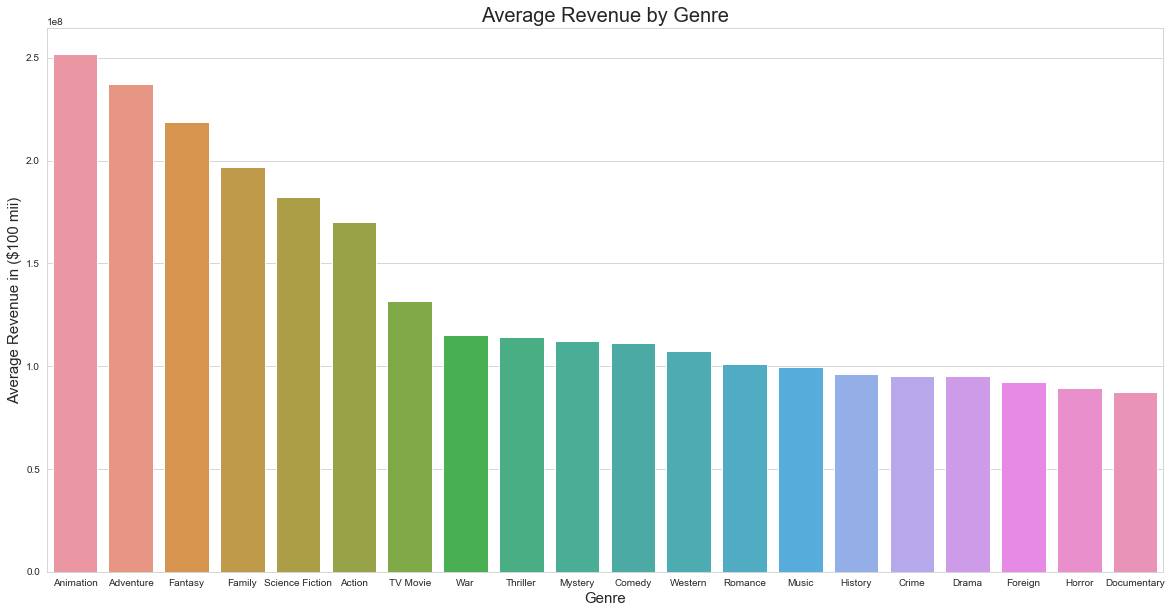

In [40]:
sns.barplot(x="Genre", y="Avg. Revenue", data=df_genre);
plt.title('Average Revenue by Genre', fontsize = 20);
plt.ylabel('Average Revenue in ($100 mii)', fontsize = 15);
plt.xlabel('Genre', fontsize = 15);

We can see that genre does affect revenue, but some more than others. For example, animation, adventure, and fantasy movies result in higher average revenue, while documentaries, horror films, and foreign films result in lower average revenues.

##### Do movies of a certain genre generate higher revenue during different seasons?

In [41]:
rev_df2 = pd.DataFrame()
row_of_list = []
for genre in genre_list:
    a = df_final[['season','revenue']].where(df_final['genres'].str.contains(genre))
    a['genre']=genre
    a.dropna(inplace=True)
    rev_df2 = pd.concat([rev_df2, a], axis=0)

In [42]:
rev_df3 = rev_df2.groupby(['genre','season'])['revenue'].mean().unstack()
rev_df4 = rev_df3.loc[['Science Fiction','Action','Family','Fantasy','Animation','Adventure']]
rev_df4 = rev_df4[['Spring','Summer','Fall','Winter']]

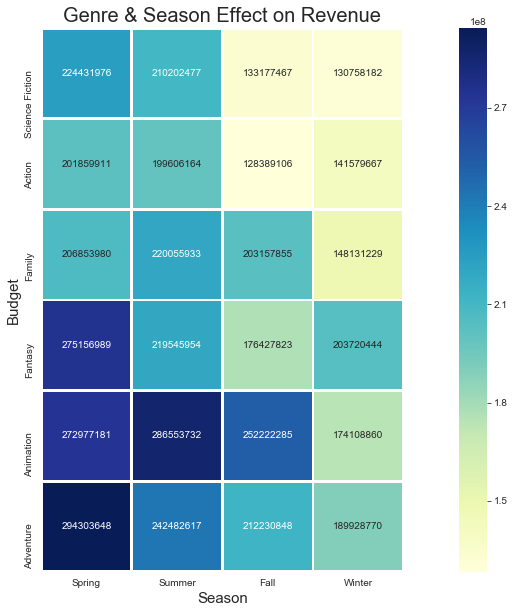

In [43]:
sns.heatmap(rev_df4, cmap='YlGnBu', annot=True, square=True, linewidths=2, fmt='.0f');
plt.title('Genre & Season Effect on Revenue', fontsize = 20);
plt.xlabel('Season', fontsize = 15);
plt.ylabel('Budget', fontsize = 15);

We decided to further explore the genres that result in the top 6 highest average revenue. From the above heatmap, we can see that adventure movies released in the spring have higher average revenue. We see similar results for animation movies released in the summer. Action movies produce less revenue in the fall.

##### Do top production companies using higher budgets result in more blockbusters?

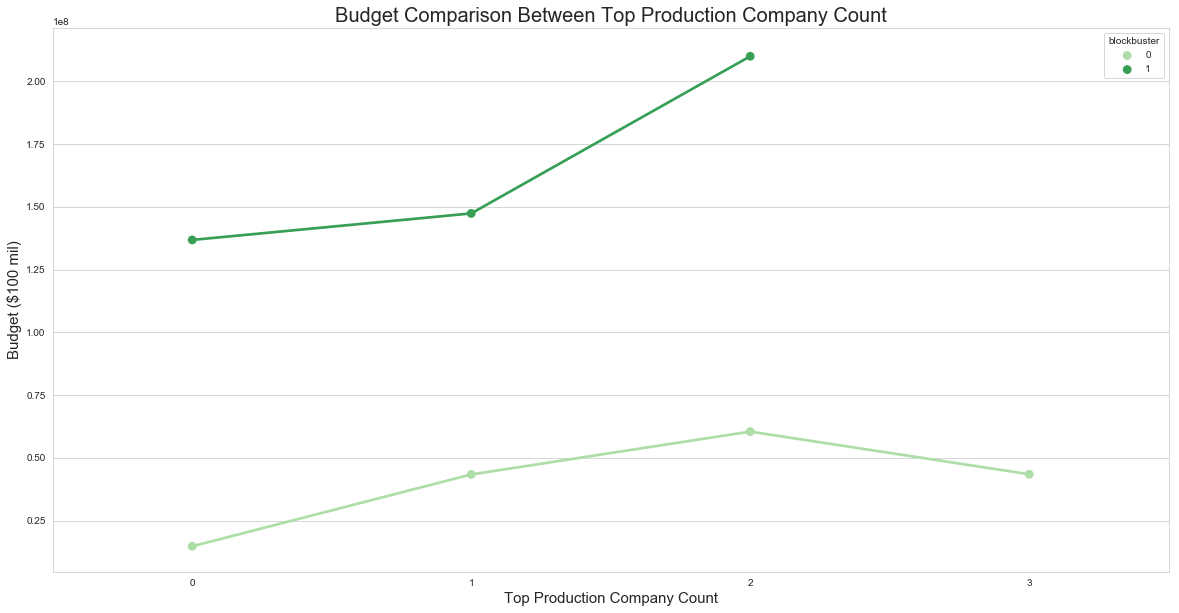

In [44]:
sns.pointplot(x='top_prod_co',y='budget',hue='blockbuster',ci=None,palette='Greens',data=df_final);
plt.title('Budget Comparison Between Top Production Company Count', fontsize = 20);
plt.ylabel('Budget ($100 mil)', fontsize = 15);
plt.xlabel('Top Production Company Count', fontsize = 15);

Here, we see that blockbusters have higher average budgets. We also see as the number of top production companies involved in a blockbuster's production increases, the budget for that blockbuster also increases. We are not certain that movies that are not blockbusters have higher budgets when additional top production companies are involved in production.

##### Does release near the Super Bowl affect a movie's revenue?

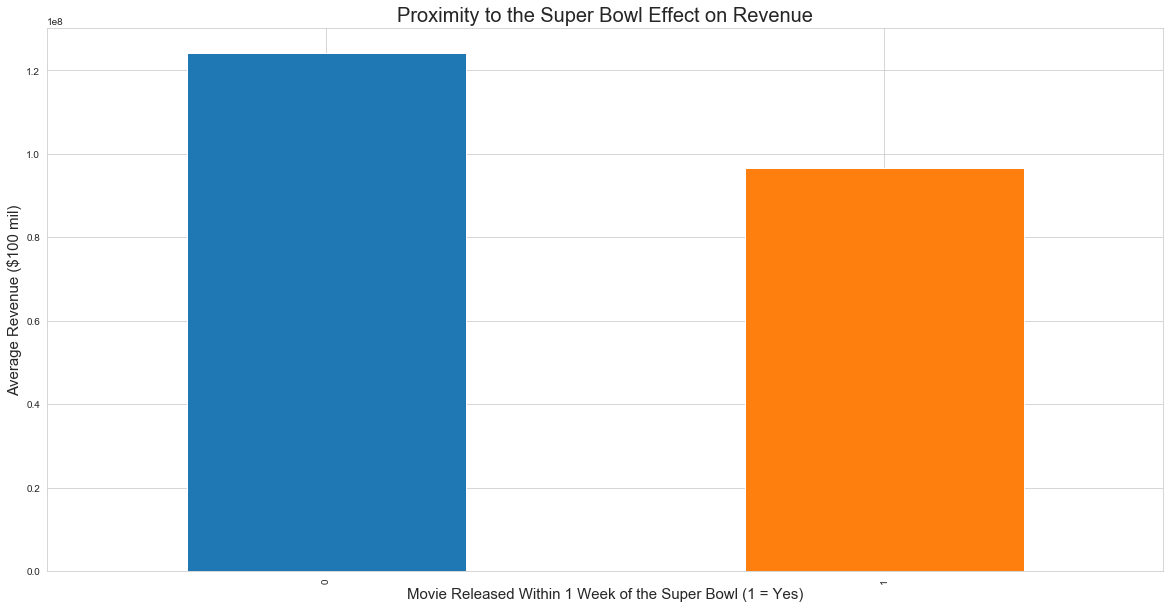

In [45]:
df_final.groupby(['superbowl_release'])['revenue'].agg('mean').plot(kind='bar');
plt.title('Proximity to the Super Bowl Effect on Revenue', fontsize = 20);
plt.ylabel('Average Revenue ($100 mil)', fontsize = 15);
plt.xlabel('Movie Released Within 1 Week of the Super Bowl (1 = Yes)', fontsize = 15);

The Super Bowl appears to affect movies revenue. In the above plot, we can see that movies that are released within a week of the Super Bowl have about 20% lower average revenue.

### Regression Results

In [46]:
df_reg = pd.read_excel(path_im + 'export3.xlsx', index_col = 0)
df_reg.head(10)

,budget,popularity,runtime,vote_average,vote_count,Western,Romance,Thriller,Animation,Crime,Horror,TV Movie,Comedy,Mystery,Music,War,Adventure,Science Fiction,Foreign,Fantasy,Drama,History,Family,Documentary,Action,country_count,top_prod_co,median_income,holiday_release,superbowl_release,stanley_cup_release,nba_release,world_series_release,population in thousands,season,a_list_dummy,blockbuster_date,revenue
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
19995,237000000,150.437577,162.0,7.2,11800,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,2,1,49276,0,0,0,0,0,307007.00,Winter,0,1,2.787965e+09
285,300000000,139.082615,169.0,6.9,4500,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,1,50303,0,0,0,0,0,301580.00,Spring,1,1,9.610000e+08
206647,245000000,107.376788,148.0,6.3,4466,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2,1,59039,0,0,0,0,1,320742.67,Fall,0,1,8.806746e+08
49026,250000000,112.312950,165.0,7.6,9106,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,53585,0,0,0,0,0,313874.22,Summer,3,1,1.084939e+09
49529,260000000,43.926995,132.0,6.1,2124,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,1,53585,0,0,0,0,0,313874.22,Spring,0,1,2.841391e+08
559,258000000,115.699814,139.0,5.9,3576,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,1,50303,0,0,0,0,0,301580.00,Spring,1,1,8.908716e+08
38757,260000000,48.681969,100.0,7.4,3330,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,50054,1,0,0,0,0,309326.09,Fall,0,1,5.917949e+08
99861,280000000,134.279229,141.0,7.3,6767,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,59039,0,0,0,0,0,320742.67,Spring,4,1,1.405404e+09
767,250000000,98.885637,153.0,7.4,5293,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,2,1,49276,1,0,0,0,0,307007.00,Summer,1,1,9.339592e+08


In [47]:
X=df_reg.iloc[:,0:-1]
s_df=pd.get_dummies(X.season,drop_first=True)
X=pd.concat([X,s_df],axis=1)
Y=df_reg.iloc[:,-1]
X=X.drop(['season'],axis=1)

In [48]:
import statsmodels.api as sm

Our regression model has an Adj. R-squared value of .762, indicating that it is a fairly decent model for predicting a movie's revenue. According to the regression output below, many variables are significant for affecting revenue in the movies dataset. The following variables are signigicant at the 5% significance level:

* Budget
* Vote average
* Vote count
* Western
* Animation
* Crime
* Adventure
* Science Fiction
* Foreign
* Family
* Documentary
* Action
* Country count
* Top production companies
* Median income
* Stanley Cup release
* Population in thousands
* A-list celebrities
* Blockbuster
* Winter

Our results are consistent with our visualizations above.

In [36]:
model = sm.OLS(endog=Y, exog=X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     368.0
Date:                Thu, 09 May 2019   Prob (F-statistic):               0.00
Time:                        12:16:40   Log-Likelihood:                -88393.
No. Observations:                4462   AIC:                         1.769e+05
Df Residuals:                    4423   BIC:                         1.771e+05
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
budget                      1.1988      0.056     21.589      0.000       1.090       1.308
popularity                3.58e+04   7.24e+04      0.494      0.621   -1.06e+05    1.78e+05
runtime                  9.284e+04   8.56e+04      1.085      0.278   -7.49e+04    2.61e+05
vote_average            -1.416e+07   1.47e+06     -9.660      0.000    -1.7e+07   -1.13e+07
vote_count               6.982e+04   2068.058     33.760      0.000    6.58e+04    7.39e+04
Western                 -2.899e+07   1.32e+07     -2.203      0.028   -5.48e+07   -3.19e+06
Romance                  4.683e+06   4.11e+06      1.140      0.254   -3.37e+06    1.27e+07
Thriller                -5.359e+06   4.11e+06     -1.304      0.192   -1.34e+07     2.7e+06
Animation                2.864e+07   8.29e+06      3.454      0.001    1.24e+07    4.49e+07
Crime                   -2.058e+07   4.61e+06     -4.465      0.000   -2.96e+07   -1.15e+07
Horror                   2.805e+06   5.49e+06      0.511      0.609   -7.95e+06    1.36e+07
TV Movie                 6.027e+07    3.7e+07      1.628      0.104   -1.23e+07    1.33e+08
Comedy                  -3.511e+06   3.74e+06     -0.940      0.347   -1.08e+07    3.81e+06
Mystery                 -7.213e+06   5.96e+06     -1.211      0.226   -1.89e+07    4.47e+06
Music                     6.96e+06   8.16e+06      0.852      0.394   -9.05e+06     2.3e+07
War                     -1.894e+07   9.91e+06     -1.912      0.056   -3.84e+07    4.81e+05
Adventure                 1.53e+07   4.87e+06      3.141      0.002    5.75e+06    2.49e+07
Science Fiction         -3.516e+07   5.15e+06     -6.824      0.000   -4.53e+07   -2.51e+07
Foreign                   4.86e+07   1.72e+07      2.831      0.005    1.49e+07    8.23e+07
Fantasy                 -1.693e+06   5.53e+06     -0.306      0.759   -1.25e+07    9.15e+06
Drama                     -1.9e+06   3.77e+06     -0.505      0.614   -9.28e+06    5.48e+06
History                 -7.055e+06   8.57e+06     -0.823      0.410   -2.39e+07    9.75e+06
Family                    1.34e+07   5.97e+06      2.245      0.025     1.7e+06    2.51e+07
Documentary              3.203e+07   1.04e+07      3.095      0.002    1.17e+07    5.23e+07
Action                  -9.656e+06   4.25e+06     -2.269      0.023    -1.8e+07   -1.31e+06
country_count           -6.346e+06   1.95e+06     -3.256      0.001   -1.02e+07   -2.52e+06
top_prod_co             -1.355e+07   3.12e+06     -4.344      0.000   -1.97e+07   -7.43e+06
median_income           -2704.9095    406.850     -6.648      0.000   -3502.539   -1907.280
holiday_release          1.818e+06   3.55e+06      0.512      0.609   -5.15e+06    8.78e+06
superbowl_release       -4.665e+06   8.43e+06     -0.553      0.580   -2.12e+07    1.19e+07
stanley_cup_release      2.307e+07   8.57e+06  

### Q&A